In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [ ]:
from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import cv2
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = smp.DeepLabV3Plus(encoder_name='resnet101', classes=6, activation='softmax').to(device)
# print(model)

In [ ]:
# summary(model, (3, 224, 224))

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
train_anger_dir='/content/drive/MyDrive/train/anger'
train_happy_dir='/content/drive/MyDrive/train/happy'
train_panic_dir='/content/drive/MyDrive/train/panic'
train_sadness_dir='/content/drive/MyDrive/train/sadness'
val_anger_dir='/content/drive/MyDrive/val/anger'
val_happy_dir='/content/drive/MyDrive/val/happy'
val_panic_dir='/content/drive/MyDrive/val/panic'
val_sadness_dir='/content/drive/MyDrive/val/sadness'

In [ ]:
anger_npz_file = np.load('/content/drive/MyDrive/segmentation/train/train_anger.npz')
happy_npz_file = np.load('/content/drive/MyDrive/segmentation/train/train_happy.npz')
panic_npz_file = np.load('/content/drive/MyDrive/segmentation/train/train_panic.npz')
sadness_npz_file = np.load('/content/drive/MyDrive/segmentation/train/train_sadness.npz')
val_anger_npz_file = np.load('/content/drive/MyDrive/segmentation/val/val_anger.npz')
val_happy_npz_file = np.load('/content/drive/MyDrive/segmentation/val/val_happy.npz')
val_panic_npz_file = np.load('/content/drive/MyDrive/segmentation/val/val_panic.npz')
val_sadness_npz_file = np.load('/content/drive/MyDrive/segmentation/val/val_sadness.npz')

In [ ]:
# import os
# import glob

# anger_image = [image for image in glob.glob(os.path.join(train_anger_dir,'*'))]
# happy_image = [image for image in glob.glob(os.path.join(train_happy_dir,'*'))]
# panic_image = [image for image in glob.glob(os.path.join(train_panic_dir,'*'))]
# sadness_image = [image for image in glob.glob(os.path.join(train_sadness_dir,'*'))]
# anger_val_image = [image for image in glob.glob(os.path.join(val_anger_dir,'*'))]
# happy_val_image = [image for image in glob.glob(os.path.join(val_happy_dir,'*'))]
# panic_val_image = [image for image in glob.glob(os.path.join(val_panic_dir,'*'))]
# sadness_val_image = [image for image in glob.glob(os.path.join(val_sadness_dir,'*'))]

In [ ]:
# # anger_data = [(image, anger_npz_file[image.split('/')[-1]]) for image in anger_image]
# anger_data = [(image, anger_npz_file[os.path.basename(image)]) for image in anger_image]
# happy_data = [(image, happy_npz_file[os.path.basename(image)]) for image in happy_image]
# panic_data = [(image, panic_npz_file[os.path.basename(image)]) for image in panic_image]
# sadness_data = [(image, sadness_npz_file[os.path.basename(image)]) for image in sadness_image]
# anger_val_data = [(image, val_anger_npz_file[os.path.basename(image)]) for image in anger_val_image]
# happy_val_data = [(image, val_happy_npz_file[os.path.basename(image)]) for image in happy_val_image]
# panic_val_data = [(image, val_panic_npz_file[os.path.basename(image)]) for image in panic_val_image]
# sadness_val_data = [(image, val_sadness_npz_file[os.path.basename(image)]) for image in sadness_val_image]

In [ ]:
class CustomSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_npz_file, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_npz_file = mask_npz_file
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_files = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        image=cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        mask = self.mask_npz_file[image_file]

        # 마스크를 PIL 이미지로 변환
        mask = Image.fromarray(mask)

        image = self.transform(image)
        mask = self.mask_transform(mask)

        return image, mask.squeeze(0)

In [ ]:
resize_size = (512, 512)
transform = transforms.Compose([
    transforms.Resize(resize_size),  # 이미지 크기 조정
    transforms.ToTensor(),           # 이미지를 텐서로 변환
])
mask_transform = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)))
])


In [ ]:
# 데이터셋 생성
train_anger_dataset = CustomSegmentationDataset(train_anger_dir, anger_npz_file, transform=transform, mask_transform=mask_transform)
train_happy_dataset = CustomSegmentationDataset(train_happy_dir, happy_npz_file, transform=transform, mask_transform=mask_transform)
train_panic_dataset = CustomSegmentationDataset(train_panic_dir, panic_npz_file, transform=transform, mask_transform=mask_transform)
train_sadness_dataset = CustomSegmentationDataset(train_sadness_dir, sadness_npz_file, transform=transform, mask_transform=mask_transform)

val_anger_dataset = CustomSegmentationDataset(val_anger_dir, val_anger_npz_file, transform=transform, mask_transform=mask_transform)
val_happy_dataset = CustomSegmentationDataset(val_happy_dir, val_happy_npz_file, transform=transform, mask_transform=mask_transform)
val_panic_dataset = CustomSegmentationDataset(val_panic_dir, val_panic_npz_file, transform=transform, mask_transform=mask_transform)
val_sadness_dataset = CustomSegmentationDataset(val_sadness_dir, val_sadness_npz_file, transform=transform, mask_transform=mask_transform)

# 데이터 로더 설정
batch_size = 8
train_datasets = ConcatDataset([
    train_anger_dataset,
    train_happy_dataset,
    train_panic_dataset,
    train_sadness_dataset
])

# 검증 데이터셋 결합
val_datasets = ConcatDataset([
    val_anger_dataset,
    val_happy_dataset,
    val_panic_dataset,
    val_sadness_dataset
])

# 데이터 로더 설정
train_loader = DataLoader(train_datasets, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_datasets, batch_size=batch_size, shuffle=False)

In [ ]:
num_epochs = 10
# criterion_ce = nn.CrossEntropyLoss()
criterion_dice = smp.losses.DiceLoss(mode='multiclass')
optimizer = optim.Adam(model.parameters(), lr=0.001)

save_dir = 'saved_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

train_losses = []
val_losses = []
best_val_loss = float('inf')

# 모델 학습
for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        inputs = inputs.to(device)
        labels = labels.long().to(device)  # Ensure labels are of type Long for CrossEntropyLoss

        optimizer.zero_grad()
        outputs = model(inputs)
        # loss_ce = criterion_ce(outputs, labels)
        loss_dice = criterion_dice(outputs, labels)
        # loss = loss_ce + loss_dice
        loss = loss_dice
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() * inputs.size(0)

    train_epoch_loss = train_running_loss / len(train_loader.dataset)

    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        for val_inputs, val_labels in tqdm(val_loader,  desc=f'Validation'):
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.long().to(device)

            val_outputs = model(val_inputs)
            # val_loss_ce = criterion_ce(val_outputs, val_labels)
            val_loss_dice = criterion_dice(val_outputs, val_labels)
            # val_loss = val_loss_ce + val_loss_dice

            val_loss = val_loss_dice
            val_running_loss += val_loss.item() * val_inputs.size(0)

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}")

    model_name = f'deeplabv3plus_model_epoch{epoch+1}_cd.pth'
    model_path = os.path.join(save_dir, model_name)
    torch.save(model.state_dict(), model_path)

    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)


Epoch 1/10:   0%|          | 0/744 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Validation: 100%|██████████| 150/150 [05:14<00:00,  2.10s/it]


Epoch [1/10], Train Loss: 0.7645, Validation Loss: 0.7636


Validation: 100%|██████████| 150/150 [05:07<00:00,  2.05s/it]


Epoch [2/10], Train Loss: 0.7614, Validation Loss: 0.7635


Validation: 100%|██████████| 150/150 [05:07<00:00,  2.05s/it]


Epoch [3/10], Train Loss: 0.7587, Validation Loss: 0.7628


Validation: 100%|██████████| 150/150 [05:06<00:00,  2.04s/it]


Epoch [4/10], Train Loss: 0.7593, Validation Loss: 0.7618


Validation: 100%|██████████| 150/150 [05:03<00:00,  2.02s/it]


Epoch [5/10], Train Loss: 0.7588, Validation Loss: 0.7618


Validation: 100%|██████████| 150/150 [05:05<00:00,  2.04s/it]


Epoch [6/10], Train Loss: 0.7554, Validation Loss: 0.7617


Validation: 100%|██████████| 150/150 [05:05<00:00,  2.03s/it]


Epoch [7/10], Train Loss: 0.7591, Validation Loss: 0.7622


Validation: 100%|██████████| 150/150 [05:02<00:00,  2.01s/it]


Epoch [8/10], Train Loss: 0.7580, Validation Loss: 0.7612


Validation: 100%|██████████| 150/150 [05:05<00:00,  2.04s/it]


Epoch [9/10], Train Loss: 0.7585, Validation Loss: 0.7615


Validation: 100%|██████████| 150/150 [05:03<00:00,  2.02s/it]


Epoch [10/10], Train Loss: 0.7585, Validation Loss: 0.7608


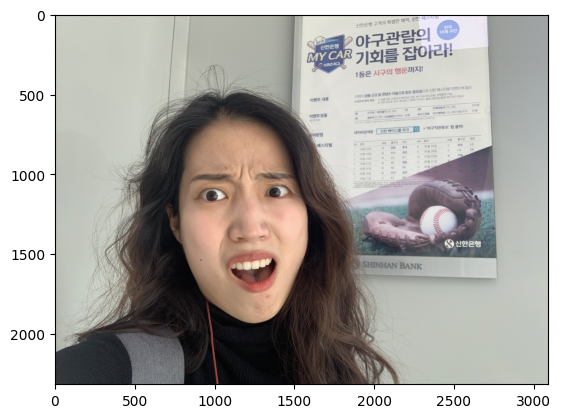

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

model_path='/content/saved_models/deeplabv3plus_model_epoch4_cd.pth'
model.load_state_dict(torch.load(model_path))
model.eval()
imput='/content/1iqxcd51059c9e9869c1c122c498ef01c6004e709c9834c1addcc3e0d7268oan9.jpg'
imput=cv2.imread(imput)
imput = cv2.cvtColor(imput, cv2.COLOR_BGR2RGB)
plt.imshow(imput)
plt.show()
imput=Image.fromarray(imput)
imput=transform(imput)
imput=imput.unsqueeze(0)
imput=imput.to(device)
with torch.no_grad():
    outputs = model(imput)

In [ ]:
outputs.shape


torch.Size([1, 6, 512, 512])

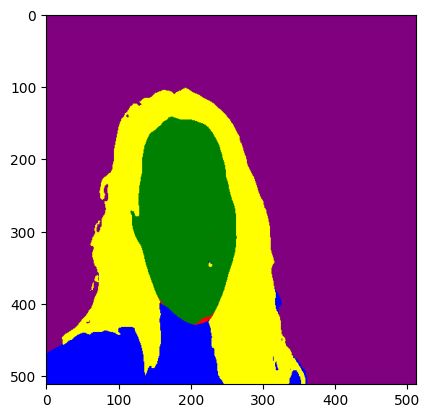

In [ ]:

segmentation_map = torch.argmax(outputs, dim=1).squeeze().cpu().numpy()
colors = {
    0: [128, 0, 128],   # 클래스 0: 보라색
    1: [255, 255, 0],   # 클래스 1: 노란색
    2: [255, 0, 0],     # 클래스 2: 빨간색
    3: [0, 128, 0],     # 클래스 3: 초록색
    4: [0, 0, 255],     # 클래스 4: 파란색
    5: [255, 165, 0]    # 클래스 5: 오렌지색
}
segmentation_colored = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8)
for class_index in range(len(colors)):
    segmentation_colored[segmentation_map == class_index] = colors[class_index]

# 시각화
plt.imshow(segmentation_colored)
plt.show()

# cmap = ListedColormap(colors)

# mask = outputs.to('cpu')
# plt.imshow(mask,cmap=cmap,vmin=0,vmax=5)
# plt.show()

In [ ]:
segmentation_map

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 4, 4, ..., 0, 0, 0],
       [4, 4, 4, ..., 0, 0, 0],
       [4, 4, 4, ..., 0, 0, 0]])